## Подготовка данных

In [9]:
import numpy as np
import torch

# !git clone https://github.com/dariush-bahrami/character-tokenizer.git
import string
import sys
from charactertokenizer import CharacterTokenizer

from torch.utils.data import TensorDataset, random_split
from tqdm import tqdm_notebook

In [10]:
# Читаю весь файл
filename = "all_data.txt"
with open(filename, 'r', encoding='utf-8') as data:
    raw_text = data.read()

In [11]:
# Оставляю только анекдоты
samples = [item.strip().split('|1|-|')[-1].replace('|', '').replace('\"', '') for item in raw_text.split('</s>')][1:]
samples[:3]

print(len(samples))

253371


In [12]:
# В качестве словаря беру все уникальные символы в тексте
values, counts = np.unique(list(raw_text), return_counts=True)
chars = ''.join(values[np.argsort(-counts)])
# chars = 'абвгдеёжзийклмнопрстуфхцчшщъыьэюя ' 
model_max_length = 512
tokenizer = CharacterTokenizer(chars, model_max_length, padding_size='right')

In [18]:
with open('bot/tokenizer_chars.txt', 'w') as fout:
    fout.write(chars)

In [6]:
# Нахожу наибольшую длину при токенизации предложения

max_len = 0

for sent in samples:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Token indices sequence length is longer than the specified maximum sequence length for this model (564 > 512). Running this sequence through the model will result in indexing errors


Max sentence length:  5187


(array([2.47052e+05, 5.79300e+03, 4.18000e+02, 6.50000e+01, 1.70000e+01,
        1.50000e+01, 3.00000e+00, 6.00000e+00, 1.00000e+00, 1.00000e+00]),
 array([   0. ,  518.5, 1037. , 1555.5, 2074. , 2592.5, 3111. , 3629.5,
        4148. , 4666.5, 5185. ]),
 <BarContainer object of 10 artists>)

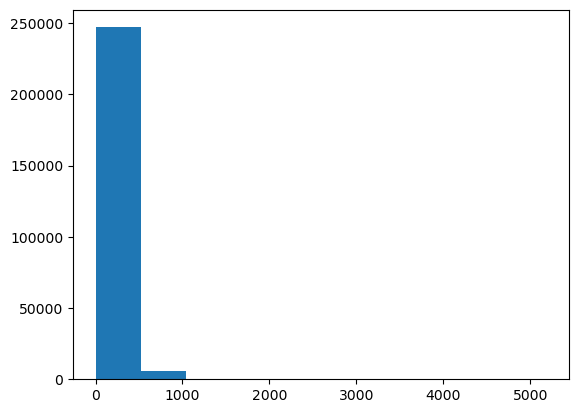

In [8]:
import matplotlib.pyplot as plt

# Но, так как практически все анекдоты вмещаются в 512 токенов, больше не беру

plt.hist([len(x) for x in samples])

In [7]:
# Перевожу все в токены
input_ids = []
attention_masks = []
MAX_LENGTH = 512
for sent in tqdm_notebook(samples):
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(samples)

print('Original: ', samples[0])
print('Token IDs:', input_ids[0])

/tmp/ipykernel_524464/2345703385.py:5: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sent in tqdm_notebook(samples):


  0%|          | 0/253371 [00:00<?, ?it/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/boris/anaconda3/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Друзья мои, чтобы соответствовать вам, я готов сделать над собой усилие и стать лучше. Но тогда и вы станьте немного хуже!
Token IDs: tensor([ 0, 62, 15, 22, 34, 24, 26,  7, 23,  8, 11, 36,  7, 31, 12,  8, 30, 29,
         7, 14,  8,  8, 12, 18, 10, 12, 14, 12, 18,  8, 18,  9, 12, 24,  7, 18,
         9, 23, 36,  7, 26,  7, 32,  8, 12,  8, 18,  7, 14, 20, 10, 19,  9, 12,
        24,  7, 13,  9, 20,  7, 14,  8, 30,  8, 48,  7, 22, 14, 11, 19, 11, 10,
         7, 11,  7, 14, 12,  9, 12, 24,  7, 19, 22, 31, 38, 10, 28,  7, 56,  8,
         7, 12,  8, 32, 20,  9,  7, 11,  7, 18, 29,  7, 14, 12,  9, 13, 24, 12,
        10,  7, 13, 10, 23, 13,  8, 32,  8,  7, 43, 22, 27, 10, 49,  1,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
         4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,

In [70]:
# Разбиваю на семплы длины seq_length

seq_length = 30
dataX = []
dataY = []
    
for sample in tqdm_notebook(input_ids):
    
    n_chars = len(sample)
#     n_vocab = len(chars)

    for i in range(0, n_chars - seq_length, 5):
        seq_in = sample[i:i + seq_length]
        seq_out = sample[i + seq_length]
        dataX.append(seq_in)
        dataY.append(seq_out)
        
        # Конец предложения, дальше нам не надо
        if seq_out == 1 or seq_out == 4:
            break

X = torch.stack(dataX)
# to 0-1
X = X / float(tokenizer.vocab_size)
y = torch.tensor(dataY)

print(len(X), len(y))

/tmp/ipykernel_524464/632983569.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sample in tqdm_notebook(input_ids):


  0%|          | 0/253371 [00:00<?, ?it/s]

5918456 5918456


In [71]:
# Тестовая и валидационная выборки

dataset = TensorDataset(X, y)

train_size = int(0.95 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

5,622,533 training samples
295,923 validation samples


In [73]:
import os
from torch import optim, nn, utils, Tensor
from torchvision.transforms import ToTensor
import lightning.pytorch as pl
import torch.nn as nn
from transformers import BertModel


# Класс модели (через лайтнинг!)
# LSTM 3 слоя размера 1024 -> два линейных слоя 

class LSTM(pl.LightningModule):
    def __init__(self, n_vocab):
        super().__init__()        
        self.lstm = nn.LSTM(input_size=1, hidden_size=1024, num_layers=3, batch_first=True, dropout=0.2)
        self.dropout = nn.Dropout(0.2)
        self.linear_1 = nn.Linear(1024, 512)
        self.relu = nn.ELU()
        self.linear_2 = nn.Linear(512, n_vocab)
        
        self.loss_fn = nn.CrossEntropyLoss()

    def training_step(self, batch, batch_idx):
        x, y = batch
        x = self.forward(x)
        
        loss = self.loss_fn(x, y)
        self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        return loss
        
    def validation_step(self, batch, batch_idx):
        x, y = batch
        x = self.forward(x)
        
        loss = self.loss_fn(x, y)
        self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        
    def forward(self, x):
        x = x.float().unsqueeze(-1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        x = self.linear_1(self.dropout(x))
        x = self.linear_2(self.relu(self.dropout(x)))
        return x

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=2e-4)
        return optimizer

lstm = LSTM(tokenizer.vocab_size)

In [74]:
# Даталоадеры батч сайз 128

train_loader = utils.data.DataLoader(train_dataset, batch_size=128, num_workers=12)
val_loader = utils.data.DataLoader(val_dataset, batch_size=128, num_workers=12)

In [75]:
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger

# Логи и сохранение

logger = TensorBoardLogger("tb_logs", name=f"lstm_data:{filename}_seq_length:{seq_length}")
checkpoint_callback = ModelCheckpoint(dirpath="models/", save_top_k=2, monitor="val_loss")

In [78]:
# Учим модель

trainer = pl.Trainer(max_epochs=20, callbacks=[checkpoint_callback], logger=logger)
trainer.fit(model=lstm, train_dataloaders=train_loader, val_dataloaders=val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params
----------------------------------------------
0 | lstm     | LSTM             | 21.0 M
1 | dropout  | Dropout          | 0     
2 | linear_1 | Linear           | 524 K 
3 | relu     | ELU              | 0     
4 | linear_2 | Linear           | 161 K 
5 | loss_fn  | CrossEntropyLoss | 0     
----------------------------------------------
21.7 M    Trainable params
0         Non-trainable params
21.7 M    Total params
86.746    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [44]:
lstm = lstm.load_from_checkpoint(checkpoint_path="models/epoch=12-step=303641.ckpt", n_vocab=tokenizer.vocab_size)
lstm.cuda()
pass

In [96]:
k = 1

In [146]:

# Generation using the trained model
# best_model, char_to_int = torch.load("single-char.pth")
# n_vocab = len(char_to_int)
# int_to_char = dict((i, c) for c, i in char_to_int.items())
# model.load_state_dict(best_model)
 
# randomly generate a prompt
# seq_length = 100
# filename = "jokes.txt"
# raw_text = open(filename, 'r', encoding='utf-8').read()
# raw_text = raw_text.lower()
# raw_text = raw_text.replace('* * *', '').replace('\n\n', '')
# start = np.random.randint(0, len(raw_text)-seq_length)
# prompt = raw_text[start:start+seq_length]
# prompt = 'Привет'
# pattern = [char_to_int[c] for c in prompt]

softmax = nn.Softmax(dim=1)
    
pattern = torch.tensor(tokenizer.encode('Штирлиц'))[:-1]
    
lstm.eval()
lstm.cuda()
print('Prompt: "%s"' % tokenizer.decode(pattern))
with torch.no_grad():
    while True:
        x = pattern / float(tokenizer.vocab_size)
        prediction = lstm(x.unsqueeze(0).cuda().float())
        p = softmax(prediction * k).cpu().flatten().detach().numpy()
        index = np.random.choice(np.arange(len(prediction.flatten())), 1, p=p)
        result = tokenizer.decode(index)
        print(result, end="")
        if index == 1:
            break
        pattern = torch.concatenate((pattern.cuda(), torch.tensor(index).cuda()))
        pattern = pattern[1:]
print()

Prompt: "[CLS]Штирлиц"
 поставили по произведина по поразаться на столе под кровать не смогут по полу тебе по полность в кармана по полу на просто приезжайте скорость - так и не понимаешь с ней с концерт по после получает по полу развелка на стенет на прокололная просто на столе по телефона по порого по запорожец по концарт предложенное получил свое постоянно потерял по столовой половину в трусы на половой половина в принципись на просто на столе без правильно называют на консерватор по математические с постоянно поступающих просто попала в темноту потом поставила за проблема на половина при получается смерти с пополнитель спрашивает денег на полность в прошлое после того же полезно поднимает девушка по полу не надо понятно, как ты на стол стану пришло в комнате за неделю на постоянно приехались в постели по телефонная проблемы и поставительное предложенное наступил костюм на порога на против на тебя на работает странно выблядеть.[SEP]


Text(0.5, 1.0, 'CrossEntropyLoss for LSTM')

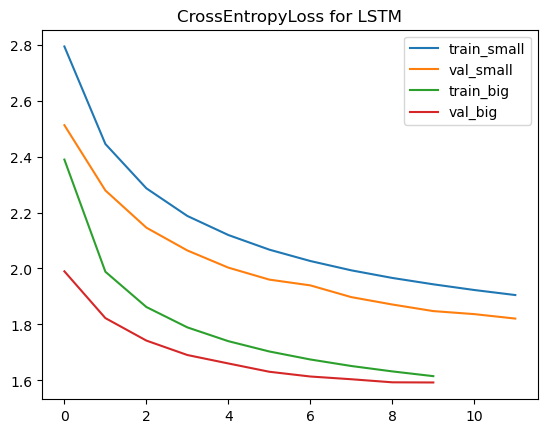

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

pd.read_csv('plots/run-lstm_data_all_data.txt_seq_length_30_version_0-tag-train_loss.csv')['Value'][:12].plot(label='train_small')
pd.read_csv('plots/run-lstm_data_all_data.txt_seq_length_30_version_0-tag-val_loss.csv')['Value'][:12].plot(label='val_small')
pd.read_csv('plots/run-lstm_data_all_data.txt_seq_length_30_version_2-tag-train_loss.csv')['Value'][:12].plot(label='train_big')
pd.read_csv('plots/run-lstm_data_all_data.txt_seq_length_30_version_2-tag-val_loss.csv')['Value'][:12].plot(label='val_big')
plt.legend()
plt.title('CrossEntropyLoss for LSTM')